# Open pose 出力 2D関節座標からの腕立て伏せ UP_DOWN 二値分類モデル学習　-＞ 動画解析例

## データの読み込み

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import perceptron


In [3]:
# COCO データセットの関節名
# Human3.6M の関節名と統一 RAnkle -> RFoot
# Human3.6M に含まれない？　or モデルの学習に用いていない REye.LEye,REar,LEar, Bkg等 は除かれる
#  StackedHourglass モデルに比べて足りない点 : Head, Hip, Spine, Thorax（胸郭)
# そもそも Stacked Hourglass は何のデータから訓練したのか? COCO を用いているのであれば同じであるべき

# 役割としては  下記の対応が考えられる Hip は RHip, LHipの中間値を用いる考えも，
# COCO : Neck < - > SH : Throax 
# COCO : Nose < - > SH : Head  

#     POSE_COCO_BODY_PARTS {
#         {0,  "Nose"},
#         {1,  "Neck"},
#         {2,  "RShoulder"},
#         {3,  "RElbow"},
#         {4,  "RWrist"},
#         {5,  "LShoulder"},
#         {6,  "LElbow"},
#         {7,  "LWrist"},
#         {8,  "RHip"},
#         {9,  "RKnee"},
#         {10, "RAnkle"},
#         {11, "LHip"},
#         {12, "LKnee"},
#         {13, "LAnkle"},
#         {14, "REye"},
#         {15, "LEye"},
#         {16, "REar"},
#         {17, "LEar"},
#         {18, "Bkg"},
#     }

COCO_NAMES = ['']*19
COCO_NAMES[0] = 'Head'
COCO_NAMES[1] = 'Thorax'
COCO_NAMES[2] = 'RShoulder'
COCO_NAMES[3] = 'RElbow'
COCO_NAMES[4] = 'RWrist'
COCO_NAMES[5] = 'LShoulder'
COCO_NAMES[6] = 'LElbow'
COCO_NAMES[7] = 'LWrist'
COCO_NAMES[8] = 'RHip'
COCO_NAMES[9] = 'RKnee'
COCO_NAMES[10] = 'RFoot'
COCO_NAMES[11] = 'LHip'
COCO_NAMES[12] = 'LKnee'
COCO_NAMES[13] = 'LFoot'
COCO_NAMES[14] = 'Reye' 
COCO_NAMES[15] = 'LEye'
COCO_NAMES[16] = 'REar'
COCO_NAMES[17] = 'LEar'
COCO_NAMES[18] = 'Bkg'

In [13]:
# 動画データに予め作成したラベルを付与 (;up = 0, up->down = 1, down=2, down->up-=3)
def extract_up_down_by_label(data_path, label_path):
    df = pd.read_csv(data_path, header=None)
    label = pd.read_csv(label_path, header=None)

    df['label'] = label
    df = df.dropna()
    df[0] = df[0].values.astype('float')
    df = df[ df['label']!=1]
    df = df[df['label']!=3]
    df['label'][df['label']==2] = 1
    
    return df

In [20]:
# ３つのラベル付した動画からデータを作成
data_path_list = ['./data/openpose-work/movie_push-ups-from-side/2-1.COCO-pose/IMG_4936.csv', \
                        './data/openpose-work/movie_push-ups-from-side/2-1.COCO-pose/IMG_4937.csv', \
                        './data/openpose-work/movie_push-ups-from-side/2-1.COCO-pose/VID_20171128_174622.csv']

label_path_list = ['./data/openpose-work/movie_push-ups-from-side/2-1.COCO-pose/IMG_4936_label.csv', \
                         './data/openpose-work/movie_push-ups-from-side/2-1.COCO-pose/IMG_4937_label.csv', \
                         './data/openpose-work/movie_push-ups-from-side/2-1.COCO-pose/VID_20171128_174622_label.csv']

df = pd.DataFrame()
for data_path, label_path in zip(data_path_list, label_path_list):
    tmp = extract_up_down_by_label(data_path, label_path)
    df = pd.concat([df,tmp]) 

In [23]:
# 入力されたモデルを 交差検証法で確認する関数
def cv(model, x, y, cv=10):
    return np.average(cross_val_score(model, x, y, cv=10, scoring='accuracy'))

In [25]:
train_x = df[df.columns[:54]]
train_y = df['label']
xgb_model = xgb.XGBClassifier()
xgb_cv = cv(xgb_model, train_x, train_y)
xgb_cv

0.96691072272083145

In [33]:
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [26]:
col_names = ['']*train_x.shape[1]
for  i in range(len(COCO_NAMES)-1):
    base = (i-1)*3
    col_names[base] = '{0}_x'.format(COCO_NAMES[i])
    col_names[base+1] = '{0}_y'.format(COCO_NAMES[i])
    col_names[base+2] = '{0}_p'.format(COCO_NAMES[i])

([<matplotlib.axis.XTick at 0x10b9d4ba8>,
 <a list of 54 Text xticklabel objects>)

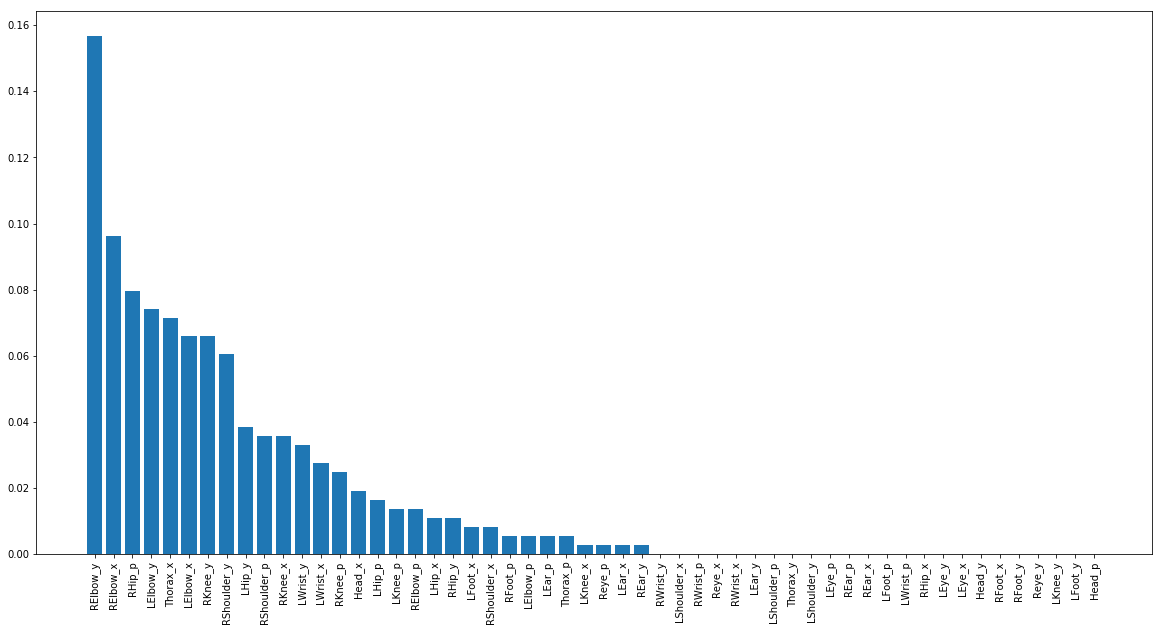

In [27]:
# xgb モデルにおける 重要度を抽出
xgb_model.fit(train_x, train_y)
imp = xgb_model.feature_importances_

sortIdx = np.argsort(imp)[::-1]

plt.figure(figsize=(20,10))
plt.bar(range(len(sortIdx)), imp[sortIdx])
plt.xticks(range(len(sortIdx)), np.array(col_names)[sortIdx], rotation=90)


In [52]:
# 上半身の値のみから モデルを学習させてみる

# target = ['Head', 'Thorax', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']
target = ['Head', 'Thorax', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']
dim_to_use_x    = np.where(np.array([name in target for name  in COCO_NAMES]))[0] * 3
dim_to_use_y    = dim_to_use_x+1
dim_to_use_p    = dim_to_use_x+2

dim_to_use = np.zeros(len(dim_to_use_x)*3,dtype=np.int32)
dim_to_use[0::3] = dim_to_use_x
dim_to_use[1::3] = dim_to_use_y
dim_to_use[2::3] = dim_to_use_p

train_x_upperbody = train_x[dim_to_use]

sc = StandardScaler()
train_x_upperbody_sc = sc.fit_transform(train_x_upperbody)

# xgbモデルの精度を 交差検証法で確認
xgb_model = xgb.XGBClassifier()
xgb_cv = cv(xgb_model, train_x_upperbody, train_y)
xgb_cv

xgb_model.fit(train_x_upperbody, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [30]:
cross_val_score(xgb_model, train_x,train_y, cv=10, scoring='accuracy')

array([ 0.98630137,  0.99315068,  1.        ,  0.71724138,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.97241379])

## 学習に用いた動画を識別した場合

([<matplotlib.axis.XTick at 0x10bc83a20>,
 <a list of 50 Text xticklabel objects>)

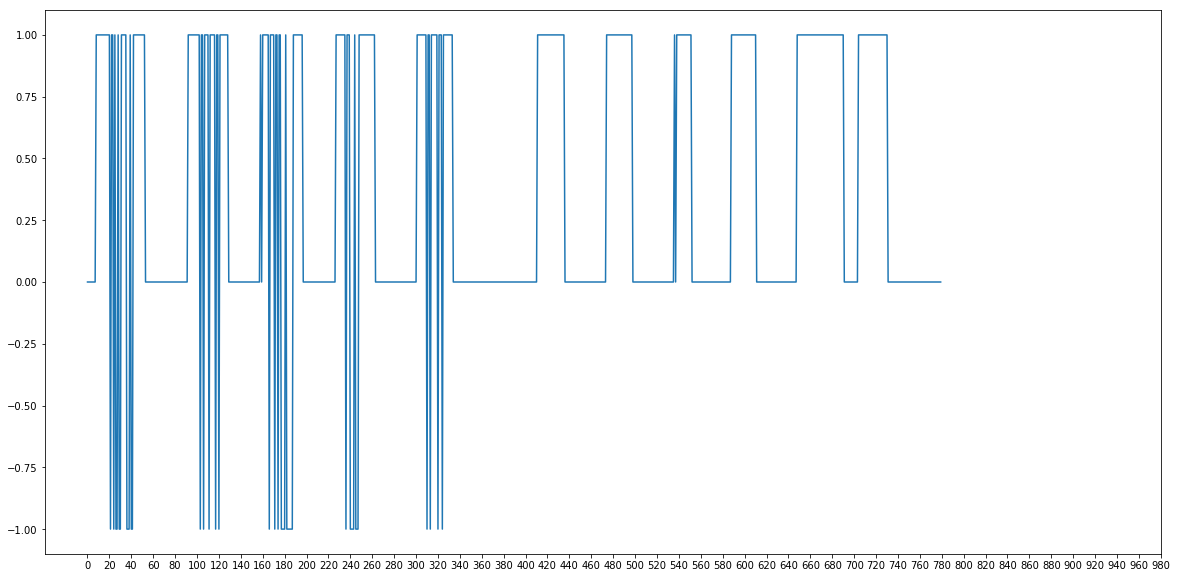

In [54]:
# データの読み込み， OpenPoseが姿勢推定に失敗したデータに対しては −１のラベルを与える

df_mv = pd.read_csv('./data/openpose-work/movie_push-ups-from-side/2-1.COCO-pose/IMG_4936.csv', header=None)
nan_Idx = np.where(pd.isnull(df_mv[1]))[0]
not_nan_Idx = np.where(pd.isnull(df_mv[1])==False)[0]
whole_predict = np.zeros(df_mv.shape[0])

df_mv = df_mv.dropna()
df_mv[0] = df_mv[0].values.astype('float')
df_mv = df_mv[df.columns[:54]]

df_mv_upperbody = df_mv[dim_to_use]

predict = xgb_model.predict(df_mv_upperbody) 
whole_predict[not_nan_Idx] = predict
whole_predict[nan_Idx] = -1 # 予測に用いなかった OpenPose 姿勢推定失敗データに対しては -1 を付与
plt.figure(figsize=(20,10))
plt.plot(whole_predict)
plt.xticks(range(0,1000,20))

([<matplotlib.axis.XTick at 0x10d0e46d8>,
 <a list of 50 Text xticklabel objects>)

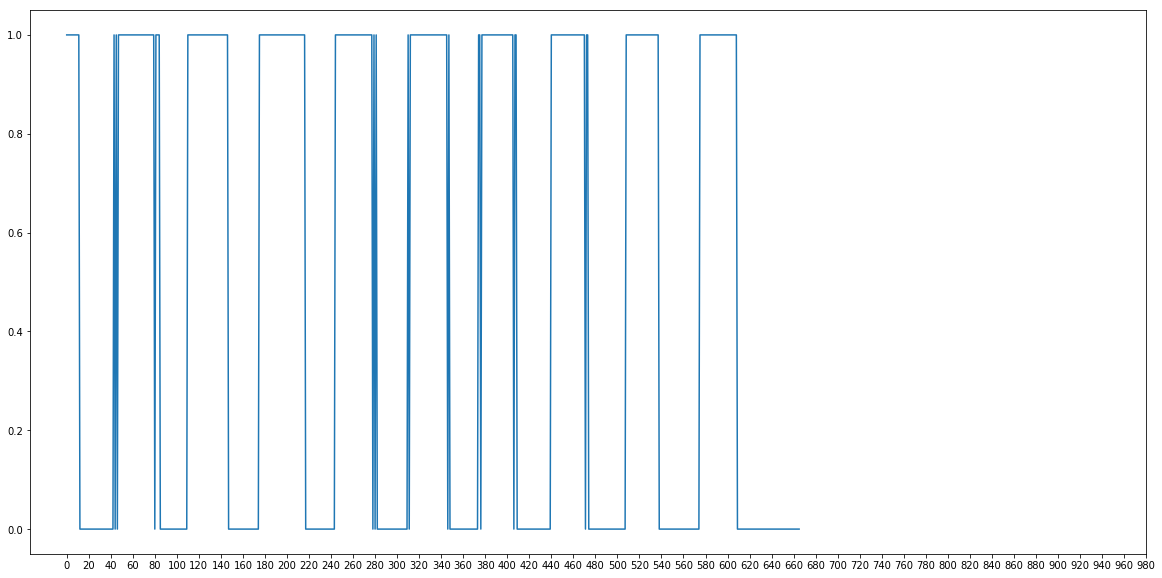

In [55]:
df_mv = pd.read_csv('./data/openpose-work/movie_push-ups-from-side/2-1.COCO-pose/VID_20171128_174622.csv', header=None)
nan_Idx = np.where(pd.isnull(df_mv[1]))[0]
not_nan_Idx = np.where(pd.isnull(df_mv[1])==False)[0]
whole_predict = np.zeros(df_mv.shape[0])

df_mv = df_mv.dropna()
df_mv[0] = df_mv[0].values.astype('float')
df_mv = df_mv[df.columns[:54]]

df_mv_upperbody = df_mv[dim_to_use]

predict = xgb_model.predict(df_mv_upperbody) 
whole_predict[not_nan_Idx] = predict
whole_predict[nan_Idx] = -1 # 予測に用いなかった OpenPose 姿勢推定失敗データに対しては -1 を付与
plt.figure(figsize=(20,10))
plt.plot(whole_predict)
plt.xticks(range(0,1000,20))

([<matplotlib.axis.XTick at 0x10feb9160>,
 <a list of 50 Text xticklabel objects>)

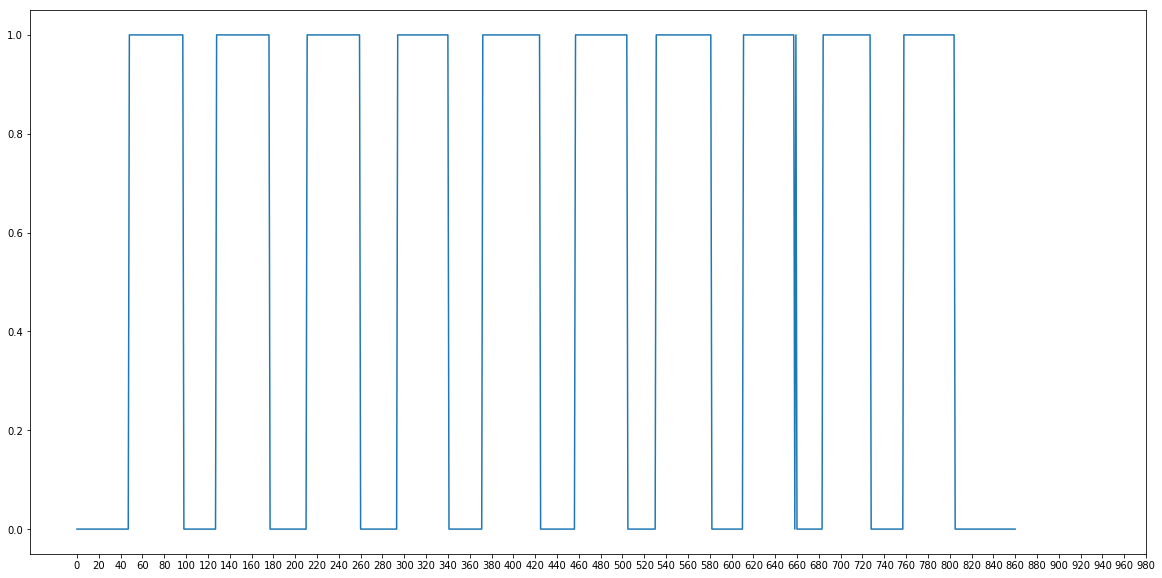

In [78]:
df_mv = pd.read_csv('./data/openpose-work/movie_push-ups-from-side/2-1.COCO-pose/IMG_4937.csv', header=None)
nan_Idx = np.where(pd.isnull(df_mv[1]))[0]
not_nan_Idx = np.where(pd.isnull(df_mv[1])==False)[0]
whole_predict = np.zeros(df_mv.shape[0])

df_mv = df_mv.dropna()
df_mv[0] = df_mv[0].values.astype('float')
df_mv = df_mv[df_mv.columns[:54]]

df_mv_upperbody = df_mv[dim_to_use]

predict = xgb_model.predict(df_mv_upperbody) 
whole_predict[not_nan_Idx] = predict
whole_predict[nan_Idx] = -1 # 予測に用いなかった OpenPose 姿勢推定失敗データに対しては -1 を付与
plt.figure(figsize=(20,10))
plt.plot(whole_predict)
plt.xticks(range(0,1000,20))

## 学習に用いていない動画で検証

([<matplotlib.axis.XTick at 0x10e9ddc50>,
 <a list of 50 Text xticklabel objects>)

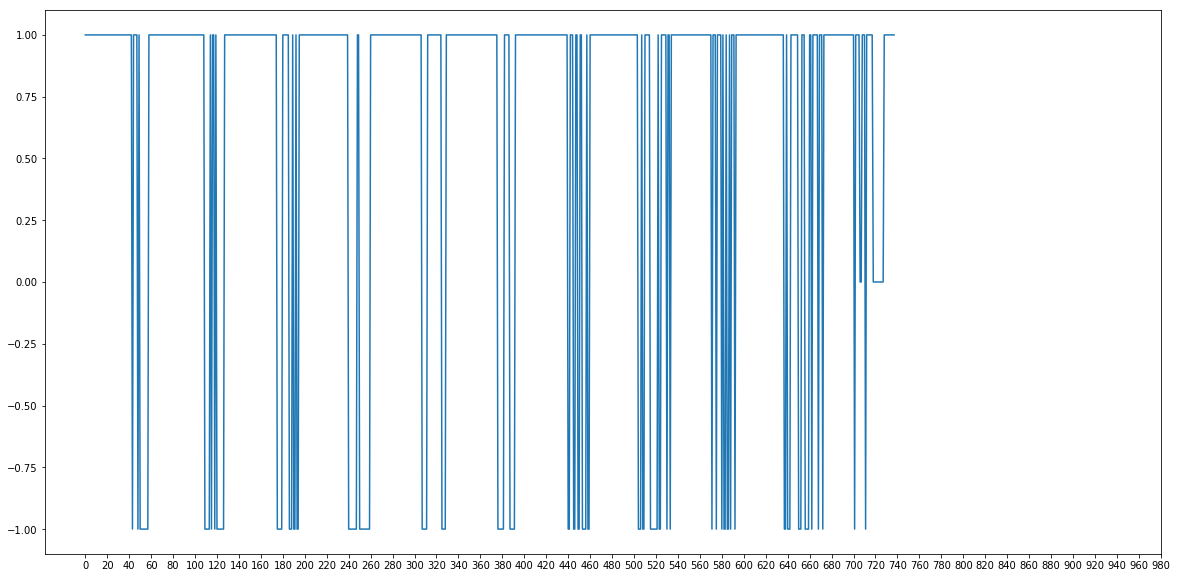

In [56]:
df_mv = pd.read_csv('./data/openpose-work/movie_push-ups-from-side/2-1.COCO-pose/IMG_7470.csv', header=None)
nan_Idx = np.where(pd.isnull(df_mv[1]))[0]
not_nan_Idx = np.where(pd.isnull(df_mv[1])==False)[0]
whole_predict = np.zeros(df_mv.shape[0])

df_mv = df_mv.dropna()
df_mv[0] = df_mv[0].values.astype('float')
df_mv = df_mv[df.columns[:54]]

df_mv_upperbody = df_mv[dim_to_use]

predict = xgb_model.predict(df_mv_upperbody) 
whole_predict[not_nan_Idx] = predict
whole_predict[nan_Idx] = -1 # 予測に用いなかった OpenPose 姿勢推定失敗データに対しては -1 を付与
plt.figure(figsize=(20,10))
plt.plot(whole_predict)
plt.xticks(range(0,1000,20))

([<matplotlib.axis.XTick at 0x10ec30cc0>,
 <a list of 50 Text xticklabel objects>)

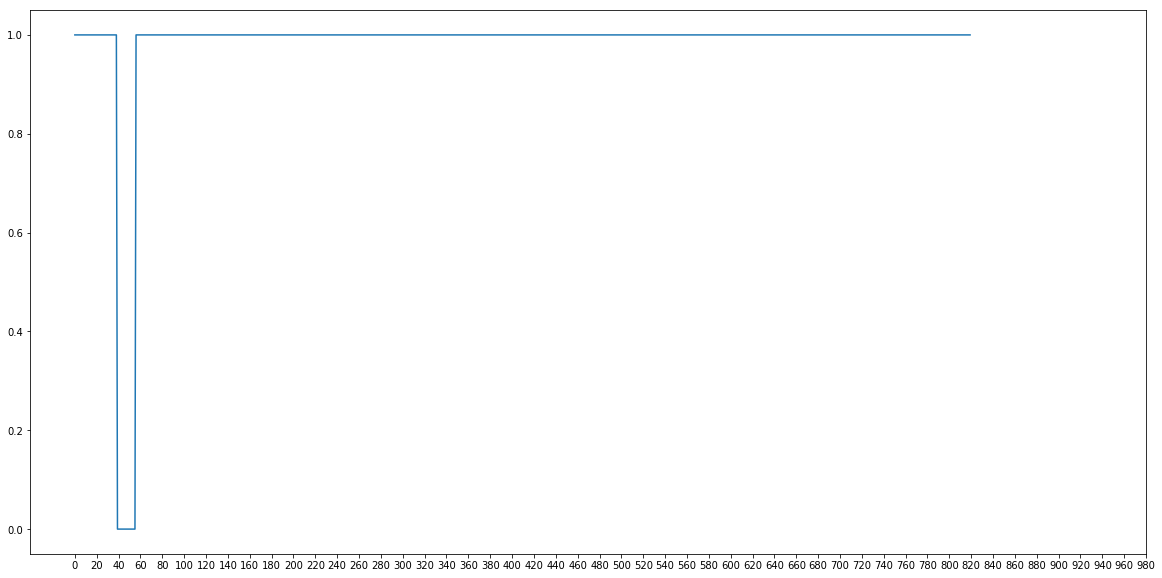

In [57]:
df_mv = pd.read_csv('./data/openpose-work/movie_push-ups-from-side/2-1.COCO-pose/IMG_7471.csv', header=None)
nan_Idx = np.where(pd.isnull(df_mv[1]))[0]
not_nan_Idx = np.where(pd.isnull(df_mv[1])==False)[0]
whole_predict = np.zeros(df_mv.shape[0])

df_mv = df_mv.dropna()
df_mv[0] = df_mv[0].values.astype('float')
df_mv = df_mv[df.columns[:54]]

df_mv_upperbody = df_mv[dim_to_use]

predict = xgb_model.predict(df_mv_upperbody) 
whole_predict[not_nan_Idx] = predict
whole_predict[nan_Idx] = -1 # 予測に用いなかった OpenPose 姿勢推定失敗データに対しては -1 を付与
plt.figure(figsize=(20,10))
plt.plot(whole_predict)
plt.xticks(range(0,1000,20))

([<matplotlib.axis.XTick at 0x10d913978>,
 <a list of 50 Text xticklabel objects>)

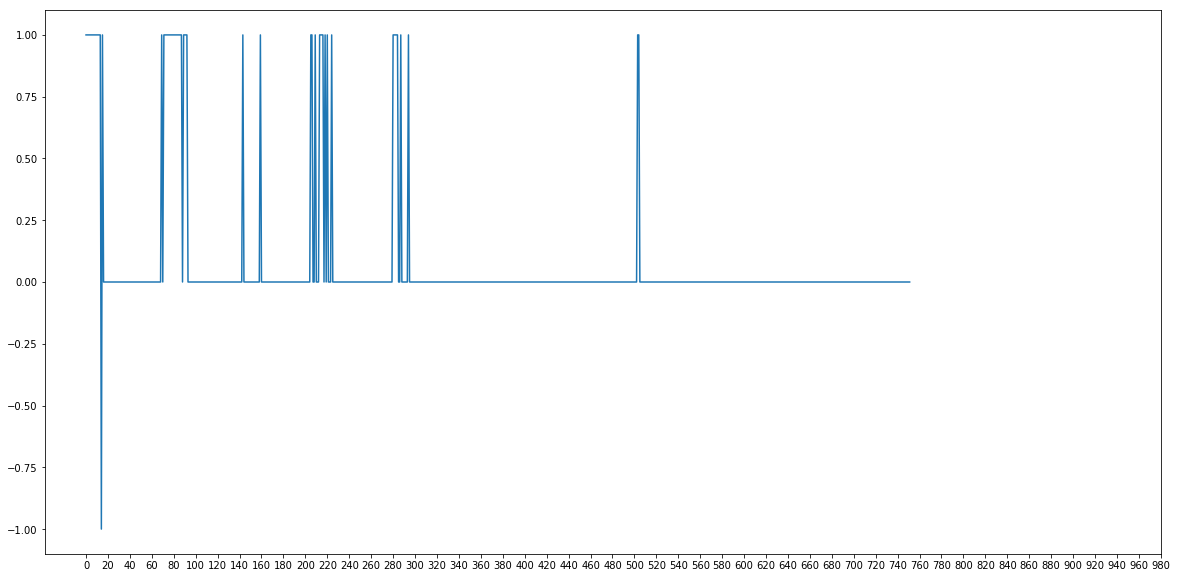

In [58]:
df_mv = pd.read_csv('./data/openpose-work/movie_push-ups-from-side/2-1.COCO-pose/VID_20171128_174702.csv', header=None)
nan_Idx = np.where(pd.isnull(df_mv[1]))[0]
not_nan_Idx = np.where(pd.isnull(df_mv[1])==False)[0]
whole_predict = np.zeros(df_mv.shape[0])

df_mv = df_mv.dropna()
df_mv[0] = df_mv[0].values.astype('float')
df_mv = df_mv[df.columns[:54]]

df_mv_upperbody = df_mv[dim_to_use]

predict = xgb_model.predict(df_mv_upperbody) 
whole_predict[not_nan_Idx] = predict
whole_predict[nan_Idx] = -1 # 予測に用いなかった OpenPose 姿勢推定失敗データに対しては -1 を付与
plt.figure(figsize=(20,10))
plt.plot(whole_predict)
plt.xticks(range(0,1000,20))

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,label
0,1660.470,512.619,0.351064,1510.360,388.9510,0.582990,1466.190,324.26700,0.407422,1357.360,...,0.0000,0.000000,1698.77,456.689,0.724189,0.000,0.0000,0.000000,IMG_4936.0001.jpg,0.0
1,1684.070,527.315,0.164571,1510.420,403.7450,0.546796,1469.260,336.05300,0.436821,1354.540,...,0.0000,0.000000,1704.72,477.279,0.752637,0.000,0.0000,0.000000,IMG_4936.0002.jpg,0.0
2,1613.500,524.380,0.056072,1516.200,427.2280,0.528951,1472.210,350.71900,0.370545,1351.570,...,0.0000,0.000000,1713.50,486.180,0.636534,0.000,0.0000,0.000000,IMG_4936.0003.jpg,0.0
3,1657.560,571.422,0.345539,1519.310,433.2480,0.538895,1489.720,362.45600,0.469115,1354.460,...,0.0000,0.000000,1636.97,436.122,0.135575,0.000,0.0000,0.000000,IMG_4936.0004.jpg,0.0
4,1625.200,556.813,0.093830,1530.970,456.7070,0.447776,1492.740,377.23000,0.404962,1354.430,...,0.0000,0.000000,1642.82,480.214,0.068339,0.000,0.0000,0.000000,IMG_4936.0005.jpg,0.0
5,1710.500,597.988,0.092629,1539.810,477.2610,0.361354,1495.760,388.97100,0.254331,1357.440,...,0.0000,0.000000,1728.11,556.741,0.576047,0.000,0.0000,0.000000,IMG_4936.0006.jpg,0.0
6,1722.250,618.605,0.122931,1539.840,486.1510,0.306435,1513.330,409.57200,0.230096,1366.180,...,0.0000,0.000000,1731.13,577.455,0.617986,0.000,0.0000,0.000000,IMG_4936.0007.jpg,0.0
7,0.000,0.000,0.000000,0.000,0.0000,0.000000,1516.340,424.32500,0.143772,1369.100,...,0.0000,0.000000,1725.20,594.979,0.225197,0.000,0.0000,0.000000,IMG_4936.0008.jpg,0.0
14,0.000,0.000,0.000000,0.000,0.0000,0.000000,1401.460,594.97700,0.290244,1457.380,...,0.0000,0.000000,1560.43,556.807,0.050260,0.000,0.0000,0.000000,IMG_4936.0015.jpg,1.0
15,0.000,0.000,0.000000,0.000,0.0000,0.000000,0.000,0.00000,0.000000,0.000,...,0.0000,0.000000,0.00,0.000,0.000000,0.000,0.0000,0.000000,IMG_4936.0016.jpg,1.0


In [63]:
col_names.append('filename')
col_names.append('label')

In [65]:
df.columns = col_names

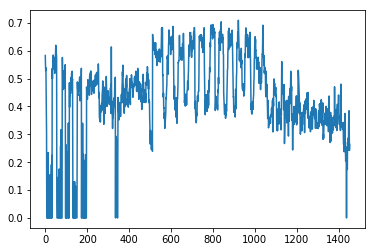

In [68]:
plt.plot(df['RShoulder_p'].values)

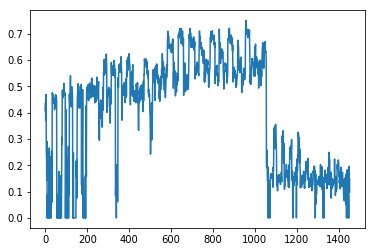

In [76]:
plt.plot(df['RElbow_p'].values)

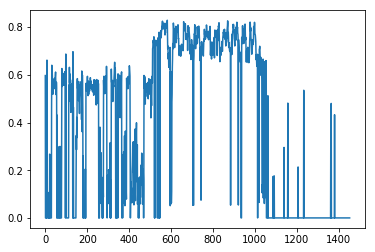

In [73]:
plt.plot(df['LShoulder_p'].values)

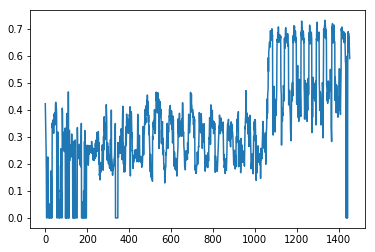

In [75]:
plt.plot(df['LElbow_p'].values)